In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from collections import Counter
from scipy.fft import fft, fftfreq, fftshift
import pickle


In [10]:
def build_dataset(df, freq):
    T = df["dt"].mean()
    N = int(np.ceil(1/freq/T*4))
    
    data = {}
    data["freqs"] = []
    for n in range(df.shape[0]//N):
        data["freqs"].extend(fftshift(fftfreq(N, T)))
    for col in ["x", "y", "fy", "fx"]:
        data[col + "f"] = []
        for n in range(df.shape[0]//N):
            data[col + "f"].extend(fftshift(fft(df[col].iloc[N*n:N*(n+1)].values)))
            
    return pd.DataFrame(data)

def prepare_frequency_domain_data(filename):
    freq = int(filename.split("Hz")[0].split("_")[-1])
    df = load_amb_sin_data(filename)
    def to_seconds(x):
        try:
            return x.delta*1e-9
        except:
            return np.nan
    
    df["dt"] = (df["datetime"] - df["datetime"].shift()).apply(to_seconds)
    df["t"]  = df["dt"].cumsum()

    T = df["dt"].mean()

    N = int(np.ceil(1/21/T*4))


    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["f_ax"] + df["f_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["f_ay"] + df["f_by"]
    #df["fx"] = df["f_ay"]
    df['ex'] = df["e_ax"] + df["e_bx"]
    #df["fx"] = df["f_ax"]
    df['ey'] = df["e_ay"] + df["e_by"]
    
    df = df[["datetime", "x", "y", "fx", "fy", "dt", "t"]]
    
    print(freq)
    
    data = build_dataset(df, freq=freq)
    data = data[np.abs(data["freqs"]) < freq*4]
    return data


def get_response(freq):
    df_x = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fx_{freq}Hz_0RPM.txt")
    df_x["axis"] = "x"
    df_y = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fy_{freq}Hz_0RPM.txt")
    df_y["axis"] = "y"
    df = pd.concat([df_x, df_y], ignore_index=False)
    
    sel_df = df[(df["freqs"] > freq-2) & (df["freqs"] < freq+1)].sort_index()

    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))
    sel_df = sel_df.loc[inds]

    Us = []
    Ys = []
    for name, group in sel_df.groupby(sel_df.index):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
    Us = np.array(Us)
    Ys = np.array(Ys)
    
    G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us,axis=0))
    C = np.imag(G) / (2*np.pi*freq)
    K = np.real(G) + (2*np.pi*freq)**2*np.array([[1, 0],[0, 1]])
    
    return {"freq": freq,
            "G"   : G,
            "C"   : C,
            "K"   : K}

#get_response(5)    

def get_files_frequencies(dirs="../amb_sin/"):
    files = os.listdir(dirs)
    files = filter(lambda x: x.endswith(".txt"), files)
    files = map(lambda x: int(x.split("Hz")[0].split("_")[-1]), files)
    files = np.unique(list(files))
    return files


responses = []
for freq in get_files_frequencies():
    responses.append(get_response(freq))

5
5
9
9
13
13
17
17
21
21
25
25
29
29
33
33
37
37
41
41
45
45
49
49
53
53
57
57
61
61
65
65
69
69


In [6]:
with open('results/frequency_eiv_results.pickle', 'wb') as handle:
    pickle.dump(responses, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
Cs = np.array([d["C"] for d in responses])
Ks = np.array([d["K"] for d in responses])
Fs = np.array([d["freq"] for d in responses])

In [8]:
Ks.shape

(17, 2, 2)

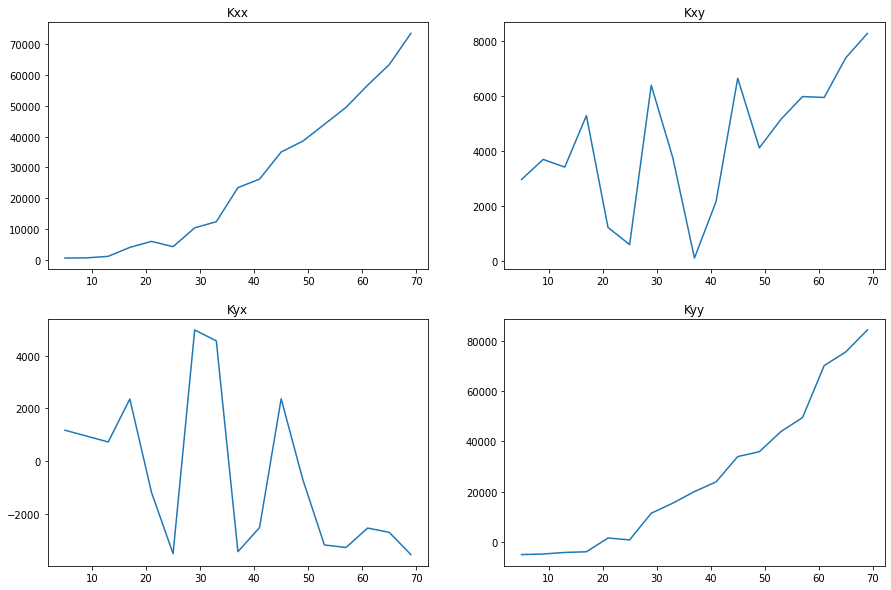

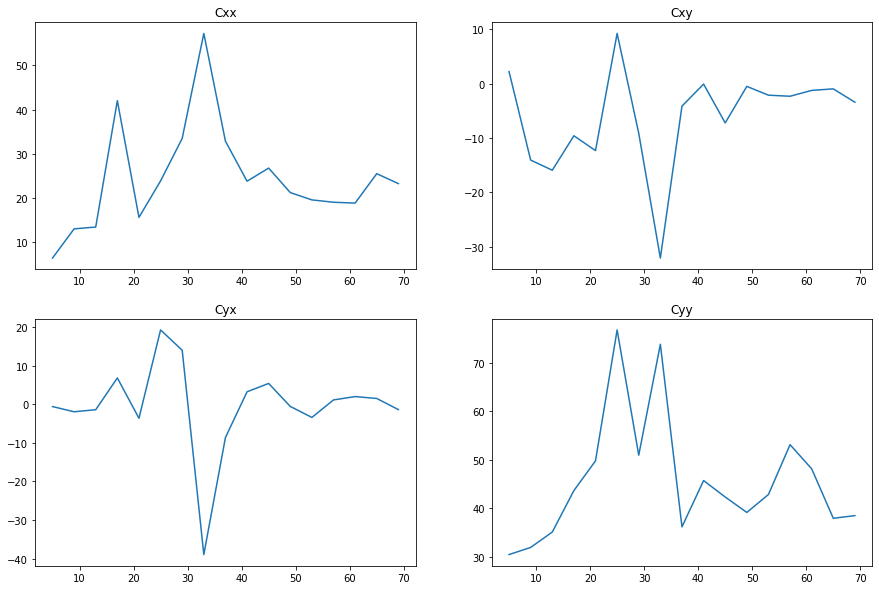

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Ks[:, 0, 0])
axs[0,0].set_title("Kxx")

axs[0,1].plot(Fs, Ks[:, 0, 1])
axs[0,1].set_title("Kxy")

axs[1,0].plot(Fs, Ks[:, 1, 0])
axs[1,0].set_title("Kyx")

axs[1,1].plot(Fs, Ks[:, 1,1])
axs[1,1].set_title("Kyy")


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Cs[:, 0, 0])
axs[0,0].set_title("Cxx")

axs[0,1].plot(Fs, Cs[:, 0, 1])
axs[0,1].set_title("Cxy")

axs[1,0].plot(Fs, Cs[:, 1, 0])
axs[1,0].set_title("Cyx")

axs[1,1].plot(Fs, Cs[:, 1,1])
axs[1,1].set_title("Cyy")

fig.show()


In [113]:
freq = 69
df_x = prepare_frequency_domain_data(filename=f"amb_sin/sine_fx_{freq}Hz_0RPM.txt")
df_x["axis"] = "x"
df_y = prepare_frequency_domain_data(filename=f"amb_sin/sine_fy_{freq}Hz_0RPM.txt")
df_y["axis"] = "y"
df = pd.concat([df_x, df_y], ignore_index=False)

69
69


In [114]:
sel_df = df[(df["freqs"] > freq-2) & (df["freqs"] < freq+1)].sort_index()

inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))
sel_df = sel_df.loc[inds]

Us = []
Ys = []
for name, group in sel_df.groupby(sel_df.index):
    U = group[["xf", "yf"]].values.transpose()
    Y = group[["fxf", "fyf"]].values.transpose()
    Us.append(U)
    Ys.append(Y)
Us = np.array(Us)
Ys = np.array(Ys)

In [119]:
G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us,axis=0))
G

array([[-114583.4971777 +10077.04630854j,
           8293.15047838 -1476.05842164j],
       [  -3526.76033189  -605.34755296j,
        -103697.97363215+16682.87701452j]])

In [147]:
#G = np.mean(Ys @ np.linalg.inv(Us), axis=0)
#G

array([[-114430.96089318+10561.50191434j,
           8336.59290944 -1089.97163863j],
       [  -3782.47372774  -444.05838651j,
        -103925.48053763+16841.80975256j]])

In [148]:
# C
C = np.imag(G) / (2*np.pi*freq)
# K
K = np.real(G) + (2*np.pi*freq)**2*np.array([[1, 0],[0, 1]])
#K = np.real(G)

print("K =", K)
print("C =", C)

K = [[73525.78532117  8336.59290944]
 [-3782.47372774 84031.26567671]]
C = [[24.36109038 -2.51412136]
 [-1.02426213 38.84720685]]


In [121]:
df

,freqs,xf,yf,fyf,fxf,axis
132,-275.824933,-0.000007-0.000018j,0.000013-0.000016j,-3.578977-3.987637j,-4.386958+0.974266j,x
133,-258.585875,0.000012-0.000000j,0.000009-0.000004j,-3.479499-2.394150j,3.683218-1.585949j,x
134,-241.346816,-0.000019+0.000003j,0.000006-0.000021j,3.727549-2.685142j,7.339244-1.230059j,x
135,-224.107758,0.000012-0.000000j,-0.000001+0.000002j,0.030928+1.954378j,0.429973-2.105833j,x
136,-206.868700,0.000090+0.000053j,-0.000003-0.000011j,5.098672+1.013514j,-1.190046+0.791540j,x
...,...,...,...,...,...,...
61045,206.868681,0.000000-0.000034j,0.000001-0.000004j,0.043426-1.444612j,-2.351415+0.956984j,y
61046,224.107738,-0.000006-0.000007j,-0.000009-0.000059j,3.610683+1.030488j,0.932557-0.485812j,y
61047,241.346795,-0.000007+0.000009j,-0.000002+0.000007j,-4.050460+0.267313j,-4.834689-2.514512j,y
61048,258.585852,0.000010+0.000008j,0.000021+0.000004j,-3.526141-4.924682j,-3.398478-0.719526j,y


(-100.0, 100.0)

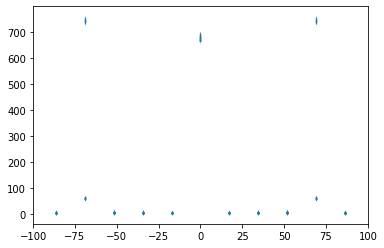

In [122]:
plt.scatter(df["freqs"], np.abs(df["fxf"]), s=0.1, alpha=0.1)
plt.xlim((-100, 100))

In [123]:
q = df[["xf", "yf"]].values
f = df[["fxf", "fyf"]].values
freqs = df[["freqs"]].values
freqs

array([[-275.82493306],
       [-258.58587475],
       [-241.34681643],
       ...,
       [ 241.34679506],
       [ 258.58585185],
       [ 275.82490864]])

In [136]:
from jax import random
from jax.experimental.optimizers import adam, sgd
from jax import numpy as jnp
import jax
%load_ext autoreload
%autoreload 2
from models.frequency_domain import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
mass = [[1, 0], [0, 1]]
def forward_pass(params, q, f, freqs, mass=jnp.array(mass)):
    """
    Um forward pass estima a força no dominio da frequencia

    """
    q = q.reshape((-1, 1))
    M = mass
    C = params[1]
    K = params[0]
    w = np.pi*2*freqs
    return jnp.squeeze(jax.lax.complex(K - jnp.square(freqs)*M, freqs*C) @ q)

batch_forward_pass = get_batch_forward_pass(mass=mass, freqs=freq)
params = initialize_params(rng, dims=2, scale=10)
loss = get_loss_function(batch_forward_pass)


In [138]:
params

[DeviceArray([[-6.630825, -5.782476],
              [ 2.076413,  9.427113]], dtype=float32),
 DeviceArray([[-14.662489 ,  -8.464476 ],
              [  6.2902365,   2.6404383]], dtype=float32)]

In [139]:
batch_forward_pass(params, q, freqs)

DeviceArray([[ 20.66405   +54.579193j , -38.816734  +48.30736j  ],
             [-32.039715   +0.6595291j, -23.08329   +10.670878j ],
             [ 43.04932    -6.8885245j, -13.6811905 +49.257046j ],
             ...,
             [ 15.368397  -19.572145j ,   3.8613057 -15.448533j ],
             [-25.282236  -20.919493j , -56.13221   -10.419552j ],
             [-49.918217  +13.554433j ,  -1.691759 +134.92639j  ]],            dtype=complex64)

In [140]:
loss(params, q, freqs, f)

DeviceArray(71.66409, dtype=float32)

In [141]:
k = jnp.array([[4300., 430.],
    [-430., 4300.]])
c = jnp.array([[43., 0.],
    [0., 43.]])
params = [K,C]

In [142]:
batch_forward_pass(params, q, freqs)

DeviceArray([[ 18.948391  +53.436966j  , -38.468815  +46.131123j  ],
             [-31.114508   -0.20216581j, -22.62786    +9.968554j  ],
             [ 41.731384   -5.8313274j , -14.310086  +46.90887j   ],
             ...,
             [ 14.327727  -19.277216j  ,   3.4755955 -14.932711j  ],
             [-24.905554  -19.549208j  , -54.515457   -8.992853j  ],
             [-48.013058  +13.921114j  ,   1.0297165+130.98547j   ]],            dtype=complex64)

In [143]:
f

array([[-4.38695767+0.97426594j, -3.57897738-3.98763719j],
       [ 3.6832182 -1.58594945j, -3.47949898-2.39415012j],
       [ 7.3392444 -1.2300593j ,  3.72754873-2.68514201j],
       ...,
       [-4.83468854-2.51451209j, -4.05045987+0.26731303j],
       [-3.39847841-0.7195256j , -3.52614142-4.92468196j],
       [ 3.10008919+3.02959862j, -5.2795916 -4.17713917j]])

In [144]:
loss(params, q, freqs, f)

DeviceArray(49.52254, dtype=float32)

In [146]:
def callback(y_pred, y_true):
    
    plt.figure(figsize=(10, 8))
    #plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred))[100:600], linestyle="dotted")
    #plt.plot(shuffler.undo_shuffle(np.squeeze(y_true))[100:600])
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.show()


train(params, q, freqs, f, batch_size=2, optimizer=adam, step_size=1e2, epochs=40, callback=None, batch_forward_pass=batch_forward_pass)

  0%|          | 1/6517 [00:00<14:58,  7.25it/s]

Epoch 0


  0%|          | 18/6517 [00:00<00:36, 179.32it/s]

Epoch 0 , mean error: 59.06368 params: [DeviceArray([[91636.38 ,  5701.843],
             [-2986.092, 85448.84 ]], dtype=float32), DeviceArray([[-16.51054 , -13.355429],
             [ 12.976528,  38.88142 ]], dtype=float32)]
Epoch 1


  0%|          | 19/6517 [00:00<00:35, 183.17it/s]

Epoch 1 , mean error: 56.948616 params: [DeviceArray([[90874.79  ,  6004.3384],
             [ -613.3689, 84275.79  ]], dtype=float32), DeviceArray([[-20.707232, -13.115502],
             [  4.96642 ,  27.035734]], dtype=float32)]
Epoch 2


  0%|          | 19/6517 [00:00<00:35, 182.25it/s]

Epoch 2 , mean error: 56.3631 params: [DeviceArray([[ 8.8161055e+04,  6.3014204e+03],
             [-3.1540657e+01,  8.5049445e+04]], dtype=float32), DeviceArray([[-12.071079,  -6.547221],
             [ 11.899834,  39.791817]], dtype=float32)]
Epoch 3


  0%|          | 17/6517 [00:00<00:40, 161.97it/s]

Epoch 3 , mean error: 55.20125 params: [DeviceArray([[88771.73  ,  6250.779 ],
             [ -643.6465, 84276.86  ]], dtype=float32), DeviceArray([[-13.361065, -15.919738],
             [  4.73068 ,  27.062191]], dtype=float32)]
Epoch 4


  0%|          | 18/6517 [00:00<00:36, 179.85it/s]

Epoch 4 , mean error: 57.86703 params: [DeviceArray([[93159.266  ,  5759.2188 ],
             [ -206.74847, 85064.79   ]], dtype=float32), DeviceArray([[28.53796 , 41.805424],
             [11.477433, 39.571804]], dtype=float32)]
Epoch 5


  0%|          | 19/6517 [00:00<00:35, 182.64it/s]

Epoch 5 , mean error: 56.861813 params: [DeviceArray([[89383.98   ,  6289.6504 ],
             [ -327.56924, 84235.93   ]], dtype=float32), DeviceArray([[16.593609 , 30.34134  ],
             [ 4.8913727, 27.031513 ]], dtype=float32)]
Epoch 6


  0%|          | 18/6517 [00:00<00:36, 179.31it/s]

Epoch 6 , mean error: 55.288235 params: [DeviceArray([[8.886426e+04, 6.139084e+03],
             [8.408111e+01, 8.417922e+04]], dtype=float32), DeviceArray([[-12.3676195, -13.314325 ],
             [  4.831518 ,  27.020086 ]], dtype=float32)]
Epoch 7


  0%|          | 18/6517 [00:00<00:36, 177.83it/s]

Epoch 7 , mean error: 57.26836 params: [DeviceArray([[92269.734  ,  5900.9053 ],
             [ -309.72696, 85072.14   ]], dtype=float32), DeviceArray([[28.973625, 42.0569  ],
             [11.15998 , 39.451027]], dtype=float32)]
Epoch 8


  0%|          | 18/6517 [00:00<00:36, 177.89it/s]

Epoch 8 , mean error: 55.930798 params: [DeviceArray([[87922.62  ,  6293.26  ],
             [ -326.3067, 84235.76  ]], dtype=float32), DeviceArray([[-24.67189 , -15.703538],
             [  4.891316,  27.031445]], dtype=float32)]
Epoch 9


  0%|          | 18/6517 [00:00<00:37, 175.04it/s]

Epoch 9 , mean error: 55.958794 params: [DeviceArray([[8.915663e+04, 6.102381e+03],
             [8.410800e+01, 8.417922e+04]], dtype=float32), DeviceArray([[-12.539928 , -13.436732 ],
             [  4.8316784,  27.020126 ]], dtype=float32)]
Epoch 10


  0%|          | 18/6517 [00:00<00:38, 170.78it/s]

Epoch 10 , mean error: 56.668095 params: [DeviceArray([[91625.01   ,  5907.362  ],
             [ -320.18787, 85081.04   ]], dtype=float32), DeviceArray([[-43.27157 , -62.437805],
             [ 11.505996,  39.618134]], dtype=float32)]
Epoch 11


  0%|          | 18/6517 [00:00<00:37, 175.07it/s]

Epoch 11 , mean error: 55.502533 params: [DeviceArray([[88077.49   ,  6423.9688 ],
             [ -339.75427, 84237.6    ]], dtype=float32), DeviceArray([[29.102602, 41.830677],
             [ 4.892166, 27.031916]], dtype=float32)]
Epoch 12


  0%|          | 19/6517 [00:00<00:35, 182.15it/s]

Epoch 12 , mean error: 56.793655 params: [DeviceArray([[9.224613e+04, 5.918310e+03],
             [8.371027e+01, 8.417927e+04]], dtype=float32), DeviceArray([[29.142958, 42.175823],
             [ 4.831746, 27.020107]], dtype=float32)]
Epoch 13


  0%|          | 18/6517 [00:00<00:36, 178.33it/s]

Epoch 13 , mean error: 55.402092 params: [DeviceArray([[87783.586  ,  6272.6904 ],
             [ -373.40918, 85087.02   ]], dtype=float32), DeviceArray([[-11.868814, -12.811922],
             [ 11.446468,  39.590023]], dtype=float32)]
Epoch 14


  0%|          | 19/6517 [00:00<00:35, 182.60it/s]

Epoch 14 , mean error: 54.5042 params: [DeviceArray([[88792.12  ,  6278.0015],
             [ -367.4465, 84241.086 ]], dtype=float32), DeviceArray([[-43.63539 , -62.448814],
             [  4.869258,  27.035555]], dtype=float32)]
Epoch 15


  0%|          | 18/6517 [00:00<00:38, 169.99it/s]

Epoch 15 , mean error: 55.516647 params: [DeviceArray([[8.8990227e+04, 6.2219771e+03],
             [8.2683975e+01, 8.4179406e+04]], dtype=float32), DeviceArray([[-43.283672 , -61.200047 ],
             [  4.8313007,  27.020166 ]], dtype=float32)]
Epoch 16


  0%|          | 18/6517 [00:00<00:37, 171.62it/s]

Epoch 16 , mean error: 57.534546 params: [DeviceArray([[92492.06   ,  5785.5034 ],
             [ -310.65298, 85072.4    ]], dtype=float32), DeviceArray([[-43.58566 , -62.11014 ],
             [ 11.166817,  39.45318 ]], dtype=float32)]
Epoch 17


  0%|          | 18/6517 [00:00<00:36, 179.06it/s]

Epoch 17 , mean error: 55.687366 params: [DeviceArray([[87575.13   ,  6313.2827 ],
             [ -326.56323, 84235.8    ]], dtype=float32), DeviceArray([[-11.978082, -13.123243],
             [  4.891368,  27.031479]], dtype=float32)]
Epoch 18


  0%|          | 17/6517 [00:00<00:38, 166.96it/s]

Epoch 18 , mean error: 57.288467 params: [DeviceArray([[9.2841789e+04, 5.8092979e+03],
             [8.4105354e+01, 8.4179219e+04]], dtype=float32), DeviceArray([[16.024899, 30.308449],
             [ 4.831622, 27.020082]], dtype=float32)]
Epoch 19


  0%|          | 18/6517 [00:00<00:36, 178.61it/s]

Epoch 19 , mean error: 55.131405 params: [DeviceArray([[87234.41  ,  6354.9897],
             [ -230.9812, 85064.8   ]], dtype=float32), DeviceArray([[-11.3735895, -12.769688 ],
             [ 11.318436 ,  39.513626 ]], dtype=float32)]
Epoch 20


  0%|          | 17/6517 [00:00<00:39, 166.58it/s]

Epoch 20 , mean error: 56.349327 params: [DeviceArray([[92653.125  ,  5660.735  ],
             [ -326.02203, 84235.73   ]], dtype=float32), DeviceArray([[-12.783223 , -14.242478 ],
             [  4.8920894,  27.031372 ]], dtype=float32)]
Epoch 21


  0%|          | 18/6517 [00:00<00:38, 170.13it/s]

Epoch 21 , mean error: 57.257404 params: [DeviceArray([[9.0272898e+04, 5.9801885e+03],
             [8.4129662e+01, 8.4179211e+04]], dtype=float32), DeviceArray([[-12.697456, -14.18326 ],
             [  4.831496,  27.020075]], dtype=float32)]
Epoch 22


  0%|          | 18/6517 [00:00<00:36, 176.89it/s]

Epoch 22 , mean error: 55.348206 params: [DeviceArray([[88209.65   ,  6227.1206 ],
             [ -317.41034, 85081.07   ]], dtype=float32), DeviceArray([[-11.412399 , -12.884906 ],
             [ 11.5268955,  39.625965 ]], dtype=float32)]
Epoch 23


 63%|██████▎   | 4103/6517 [00:22<00:13, 181.16it/s]


KeyboardInterrupt: 